In [1]:
import sys
sys.path.append('../')
import scipy.io
from utils.mat_to_tfrecord_analysis import formatSessionData
from pathlib import Path
import numpy as np
import os

session = 't17.2024.04.24'
blocks = [2,3,6,7,8,9,10]
trialsToRemove = []
dataDir = str(Path('../Data', 't17', session, 'brainToText'))
data = formatSessionData(
                      blocks,
                      trialsToRemove,
                      dataDir,
                      start_offset=-450,
                      end_offset=250,
                      channels_to_exclude=[],
                      channels_to_zero=[],
                      includeThreshCrossings=True,
                      includeSpikePower=True,
                      spikePowerMax=10000,
                      globalStd=True,
                      zscoreData=True,
                      bin_compression_factor=1)

inputFeatures = data['inputFeatures']
cues = data['transcriptions']
cues = np.array([cue.strip() for cue in cues])
all_cues, counts = np.unique(cues,return_counts=True)
arrays = {'All Channels': np.arange(0,384)}

RedisMat file for block 2: ../Data/t17/t17.2024.04.24/brainToText/RedisMat/20240424_135122_(2).mat
RedisMat file for block 3: ../Data/t17/t17.2024.04.24/brainToText/RedisMat/20240424_140526_(3).mat
RedisMat file for block 6: ../Data/t17/t17.2024.04.24/brainToText/RedisMat/20240424_161851_(6).mat
RedisMat file for block 7: ../Data/t17/t17.2024.04.24/brainToText/RedisMat/20240424_163106_(7).mat
RedisMat file for block 8: ../Data/t17/t17.2024.04.24/brainToText/RedisMat/20240424_164356_(8).mat
RedisMat file for block 9: ../Data/t17/t17.2024.04.24/brainToText/RedisMat/20240424_171508_(9).mat
RedisMat file for block 10: ../Data/t17/t17.2024.04.24/brainToText/RedisMat/20240424_172909_(10).mat


In [2]:
mapping_lateral =  ['LEFT INDEX - In to Palm',
           'LEFT INDEX - Straight Downwards',           
           'LEFT INDEX - Extend Upwards',
           'LEFT THUMB - In to Palm',
           'LEFT THUMB - Straight Downwards',
           'LEFT THUMB - Extend Upwards',
           'RIGHT INDEX - In to Palm',
           'RIGHT INDEX - Straight Downwards',
           'RIGHT INDEX - Extend Upwards',
           'RIGHT THUMB - In to Palm',
           'RIGHT THUMB - Straight Downwards',           
           'RIGHT THUMB - Extend Upwards']

mapping_medial = ['LEFT PINKY - In to Palm',
           'LEFT PINKY - Straight Downwards',           
           'LEFT PINKY - Extend Upwards',
           'LEFT RING - In to Palm',
           'LEFT RING - Straight Downwards',           
           'LEFT RING - Extend Upwards',
            'RIGHT PINKY - In to Palm',
           'RIGHT PINKY - Straight Downwards',
           'RIGHT PINKY - Extend Upwards',
           'RIGHT RING - In to Palm',
           'RIGHT RING - Straight Downwards',
           'RIGHT RING - Extend Upwards',]

In [3]:
gathered_trials_lateral = []
for i, k in enumerate(mapping_lateral):
    indices = np.array(np.argwhere(cues == k)).flatten()
    all_trials_this_phone = np.zeros((indices.shape[0],  inputFeatures[0].shape[0], inputFeatures[0].shape[-1]))    
    for j, trial in enumerate(indices):
        all_trials_this_phone[j,:inputFeatures[trial].shape[0] ,:] = np.nan_to_num(inputFeatures[trial][:950, :])
    gathered_trials_lateral.append(all_trials_this_phone)

gathered_trials_medial = []
for i, k in enumerate(mapping_medial):
    indices = np.array(np.argwhere(cues == k)).flatten()
    all_trials_this_phone = np.zeros((indices.shape[0],  inputFeatures[0].shape[0], inputFeatures[0].shape[-1]))    
    for j, trial in enumerate(indices):
        all_trials_this_phone[j,:inputFeatures[trial].shape[0] ,:] = np.nan_to_num(inputFeatures[trial][:950, :])
    gathered_trials_medial.append(all_trials_this_phone)

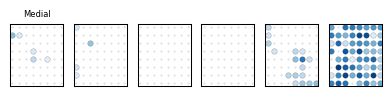

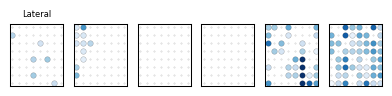

In [4]:
import scipy.stats
import matplotlib.pyplot as plt
from utils.analysisT17 import makeTuningHeatmapT17, heatmapPlotCirclesT17

range_to_apply = [450,550]

tuningR2_medial, tuningPVal_medial = makeTuningHeatmapT17(mapping_medial, gathered_trials_medial, range_to_apply, num_conditions=12)
tuningR2_lateral, tuningPVal_lateral = makeTuningHeatmapT17(mapping_lateral, gathered_trials_lateral, range_to_apply, num_conditions=12)
heatmapPlotCirclesT17(tuningR2_medial,
            tuningPVal_medial<0.0001,
            [0,0.7], 
            ['Medial'],
            'all')
plt.savefig('T17ArraysFVAFsMedial.pdf',bbox_inches='tight')
plt.show()

heatmapPlotCirclesT17(tuningR2_lateral,
            tuningPVal_lateral<0.0001,
            [0,0.7], 
            ['Lateral'],
            'all')

plt.savefig('T17ArraysFVAFsLateral.pdf',bbox_inches='tight')
plt.show()

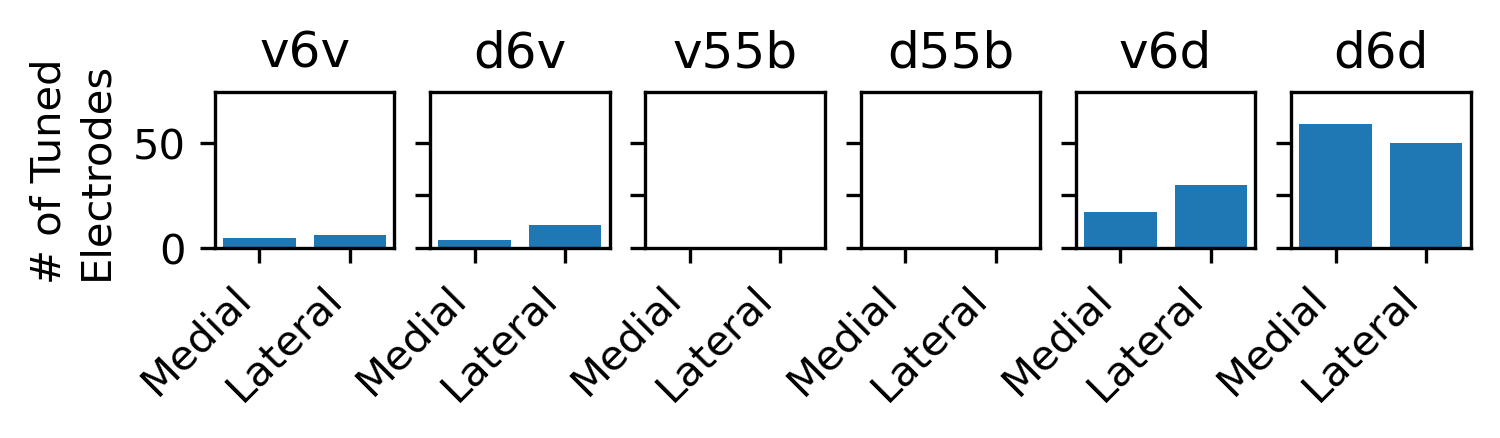

In [6]:
tuningPVal_all = np.concatenate([tuningPVal_medial, tuningPVal_lateral], axis=1)
chanSets = [np.arange(0,64).astype(np.int32), 
               np.arange(64,128).astype(np.int32),
               np.arange(128,192).astype(np.int32),
               np.arange(192,256).astype(np.int32),
               np.arange(256,320).astype(np.int32),
               np.arange(320,384).astype(np.int32),]

titles = ['v6v', 'd6v', 'v55b', 'd55b', 'v6d', 'd6d']
plt.figure(dpi=300, figsize=(6*0.90, 0.75*0.90))
for setIdx in range(len(chanSets)):
    plt.subplot(1,6,setIdx+1)
    categories = np.sum(tuningPVal_all[chanSets[setIdx],:]<0.0001, axis=0)
    plt.bar(np.arange(0, len(categories)).astype(np.int32), categories)
    plt.ylim([0,74])
    plt.xticks(ticks=np.arange(0,2), labels=['Medial', 'Lateral'], rotation=45, ha="right")
    if setIdx>0:
        plt.yticks(ticks=[0,25, 50],labels=[])
    if setIdx==0:
        plt.ylabel('# of Tuned\nElectrodes')
    plt.title(titles[setIdx])
plt.savefig('T17NumTunedChannels.pdf',bbox_inches='tight')
plt.show()